In [1]:
# === colab configuration ===
# p.s. when training on colab, weights are saved on Drive (directory DSCAS/weights).
# p.p.s. skip this cell if running demo file locally!

! pip install torch-summary
! pip install ray
from google.colab import drive
import sys

# setting paths
repository_path = '/content/deep-seasonal-color-analysis-system/'
dataset_path = repository_path + 'headsegmentation_dataset_ccncsa/'
dataset_path_drive = '/content/drive/MyDrive/DSCAS/headsegmentation_dataset_ccncsa/'
weights_path = repository_path + 'models/weights/'
weights_path_drive = '/content/drive/MyDrive/DSCAS/weights/'
sys.path.insert(0, repository_path)

# cloning project repository and downloading dataset
drive.mount('/content/drive')
! test ! -d $repository_path && git clone https://github.com/mrcmich/deep-seasonal-color-analysis-system.git
! test ! -d $dataset_path && cp -R $dataset_path_drive $dataset_path
%cd $repository_path

# setting branch and pulling updates
branch = 'fastscnn_hyperparameters_tuning__refactoring'
! git checkout $branch
! git pull origin $branch

executing_on_colab = True

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 KB 12.4 MB/s eta 0:00:00
Mounted at /content/drive
Cloning into 'deep-seasonal-color-analysis-system'...
remote: Enumerating objects: 1094, done.
remote: Counting objects: 100% (575/575), done.
remote: Compressing objects: 100% (299/299), done.
remote: Total 1094 (delta 302), reused 456 (delta 274), pack-reused 519
Receiving objects: 100% (1094/1094), 270.74 MiB | 36.33 MiB/s, done.
Resolving deltas: 100% (621/621), done.
/content/deep-seasonal-color-analysis-system
Updating files: 100% (249/249), done.
Branch 'main__fastscnn_hyperparameters_tuning' set up to track remote branch '

In [2]:
import torch
from torch import nn
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from models import dataset, training_and_testing
from models.local.FastSCNN.models import fast_scnn
from metrics_and_losses import metrics
from utils import segmentation_labels, utils, custom_transforms
import matplotlib.pyplot as plt
from palette_classification import color_processing
from models import config

try:
  executing_on_colab
except NameError:
  executing_on_colab = False
  weights_path = config.WEIGHTS_PATH
  dataset_path = config.DATASET_PATH

In [4]:
# === defining transforms ===

tH, tW = 512, 512
bilateral_filter = custom_transforms.BilateralFilter(sigma_color=50, sigma_space=100, diameter=7)

test_image_transform = T.Compose([
    T.Resize((tH, tW)),
    bilateral_filter,
    T.Normalize(config.NORMALIZE_MEAN, config.NORMALIZE_STD)])

test_target_transform = T.Compose([T.Resize((tH, tW))])

# fetching dataset
n_classes = len(segmentation_labels.labels)
img_paths, label_paths = dataset.get_paths(dataset_path, file_name=config.DATASET_INDEX_NAME)
_, X_test, _, Y_test = train_test_split(img_paths, label_paths, test_size=0.20, random_state=99, shuffle=True)
test_dataset = dataset.MyDataset(X_test, Y_test, test_image_transform, test_target_transform)

batch_size = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# loading tuned model
model_name = 'fast_scnn_ccncsa_tuned'
model = fast_scnn.FastSCNN(n_classes)
model = nn.DataParallel(model)
model.load_state_dict(torch.load(weights_path + model_name + '.pth'))

# testing model on test dataset
test_score_fn = metrics.batch_IoU
label_names = list(segmentation_labels.labels.keys())
class_weights = torch.tensor(config.CLASS_WEIGHTS, device=device)
batch_IoU = training_and_testing.test_model(device, model, test_dataset, batch_size, test_score_fn)
batch_IoU_with_labels = {label: score for label, score in list(zip(label_names, batch_IoU.tolist()))}
batch_mIoU = batch_IoU.mean().item()
batch_weighted_mIoU = utils.tensor_weighted_average(batch_IoU, class_weights).item()
for label in batch_IoU_with_labels:
    print(f'batch_IoU_{label}: {batch_IoU_with_labels[label]}')
print(f'batch_mIoU={batch_mIoU}')
print(f'batch_weighted_mIoU={batch_weighted_mIoU}')

Device: cuda.

Inference completed in around 214 seconds.
batch_IoU_background: 0.9534763693809509
batch_IoU_lips: 0.5397905707359314
batch_IoU_eyes: 0.48451998829841614
batch_IoU_nose: 0.6808378100395203
batch_IoU_skin: 0.8546070456504822
batch_IoU_hair: 0.7814543843269348
batch_IoU_eyebrows: 0.48412400484085083
batch_IoU_ears: 0.6565645337104797
batch_IoU_teeth: 0.7216663360595703
batch_IoU_beard: 0.7817790508270264
batch_IoU_sunglasses: 0.7108455896377563
batch_mIoU=0.6954241991043091
batch_weighted_mIoU=0.6748695373535156


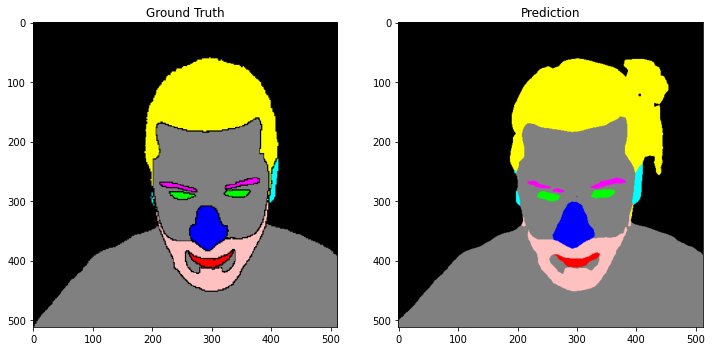

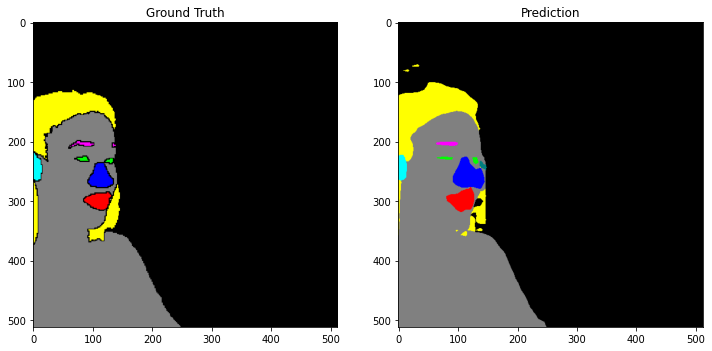

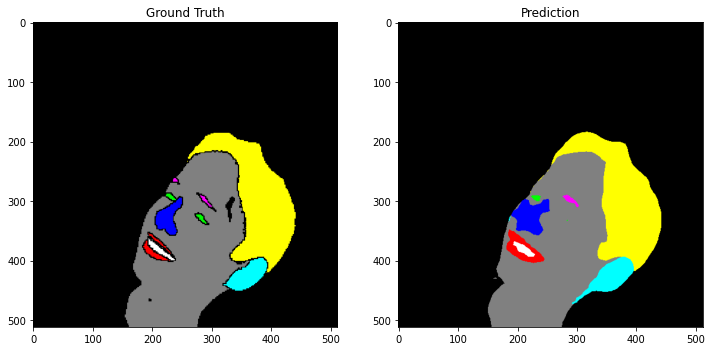

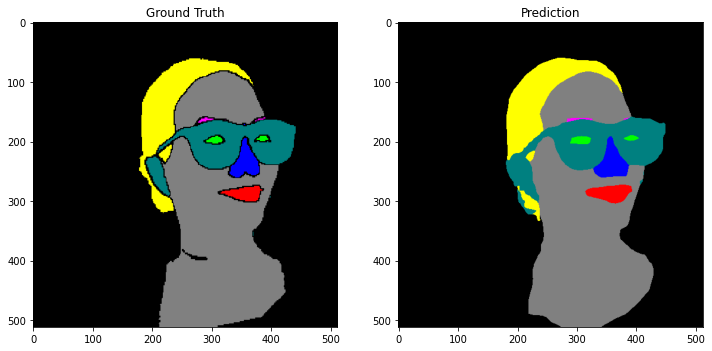

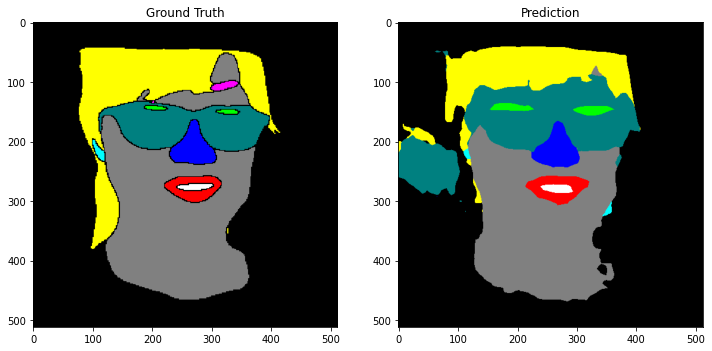

In [6]:
# === plotting some examples from test dataset ===

n_examples = 5
random_images = torch.zeros((n_examples, 3, tH, tW))
random_targets = torch.zeros((n_examples, n_classes, tH, tW))

for i in range(n_examples):
    random_idx = torch.randint(high=len(test_dataset), size=(1,))
    random_image, random_target = test_dataset[random_idx]
    random_images[i] = random_image
    random_targets[i] = random_target

with torch.no_grad():
    model.eval()
    random_images = random_images.to(device)
    random_output = model(random_images)[0]

channels_max, _ = torch.max(random_output, axis=1)
random_predictions = (random_output == channels_max.unsqueeze(axis=1)).to('cpu')

for i in range(n_examples):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Ground Truth')
    plt.imshow(utils.from_DHW_to_HWD(
        color_processing.colorize_segmentation_masks(random_targets[i], segmentation_labels.labels)))
    plt.subplot(1, 2, 2)
    plt.title('Prediction')
    plt.imshow(utils.from_DHW_to_HWD(
        color_processing.colorize_segmentation_masks(random_predictions[i], segmentation_labels.labels)))